In [381]:
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/data-storm-10/credit_card_default_train.csv
/kaggle/input/data-storm-10/DATA STORM 1.0 - First Round Competition Guidlines.pdf
/kaggle/input/data-storm-10/credit_card_default_test.csv
/kaggle/input/data-storm-10/Credit_card_default - Business Problem - Assessment Criteria - Data Dictionary.xlsx


credit_card_default_train=pd.read_csv('/kaggle/input/data-storm-10/credit_card_default_train.csv')
credit_card_default_test=pd.read_csv('/kaggle/input/data-storm-10/credit_card_default_test.csv')

In [382]:
credit_card_default_train=pd.read_csv('/kaggle/input/data-storm-10/credit_card_default_train.csv')
credit_card_default_test=pd.read_csv('/kaggle/input/data-storm-10/credit_card_default_test.csv')

In [383]:
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score    
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
import itertools
from numpy import median


In [384]:
target_names = ['0','1']

def print_report(X_train, X_val, y_train, y_val, model):
    print('Train Report')
    y_pred_train = model.predict(X_train)
    print(classification_report(y_train, y_pred_train, target_names = target_names))

    print('Validation Report')
    y_pred_val = model.predict(X_val)
    print(classification_report(y_val, y_pred_val, target_names = target_names))
    
    print('Training f1-score(weighted): %f' % f1_score(y_train, y_pred_train, average = 'weighted'))
    print('Validation f1-score(weighted): %f' % f1_score(y_val, y_pred_val, average = 'weighted'))

In [385]:
_id = 'Client_ID'
target = 'NEXT_MONTH_DEFAULT'

X = credit_card_default_train.drop(target, axis =1)
y = credit_card_default_train.loc[:, target]

# Save Client_IDs of the tests in order to append at the end
test_client_ids =  credit_card_default_test[_id]

X.drop(_id, axis = 1, inplace = True)
credit_card_default_test.drop(_id, axis = 1, inplace = True)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

X_train_copy= X_train.copy()
X_val_copy = X_val.copy()

In [386]:
unused_cols = ['Balance_Limit_V1', 'EDUCATION_STATUS', 'MARITAL_STATUS', 'AGE']
pay_cols = ['PAY_JULY','PAY_AUG','PAY_SEP','PAY_OCT','PAY_NOV','PAY_DEC']
paid_cols = ['PAID_AMT_JULY', 'PAID_AMT_AUG', 'PAID_AMT_SEP', 'PAID_AMT_OCT', 'PAID_AMT_NOV', 'PAID_AMT_DEC']
due_cols = ['DUE_AMT_JULY', 'DUE_AMT_AUG', 'DUE_AMT_SEP', 'DUE_AMT_OCT', 'DUE_AMT_NOV', 'DUE_AMT_DEC']
categorical_cols = ['EDU_ENC', 'MARITAL_ENC', 'AGE_ENC', 'Gender']

In [387]:
def balance_limit_encoder(value):
    last = value[-1]
    value = value[:-1]
    int_val = 0
    if last == 'K':
        int_val = float(value) * 1e3
    elif last == 'M':
        int_val = float(value) * 1e6
    return int_val/1e6
    
marital_status_encoder = LabelEncoder()
edu_status_encoder = LabelEncoder()
age_encoder = LabelEncoder()

def balance_limit_to_num(dataset):
    return dataset.assign(Balance_Limit_Enc = dataset['Balance_Limit_V1'].map(balance_limit_encoder))

def func_age_encode(data):
  if(data == '31-45'):
    return (31+45)/2
  elif data == 'Less than 30':
    return 15
  elif data == '46-65':
    return (65-46)/2
  elif data == 'More than 65':
    return 65
  else:
    return 0

# Fit Encoders
def fit_encoders(fit_data):
    marital_status_encoder.fit(fit_data['MARITAL_STATUS'])
    edu_status_encoder.fit(fit_data['EDUCATION_STATUS'])
    age_encoder.fit(fit_data['AGE'])


In [388]:
scaler = StandardScaler()

In [389]:
def generate_pay_value_frequency_features(dataset):
    '''Generates a column for each of the possible values for PAY_* columns with the frequency of
    each value in  a row'''

    cols = {'PAY_'+str(i) : [] for i in range(-2,10)}

    for index, row in dataset.iterrows():
        counts = {i : 0 for i in range(-2,10)}
      
        for i in pay_cols:
            item = int(row[i])
            counts[item] = counts.get(item, 0) + 1
        for key, value in counts.items():
            cols['PAY_'+str(key)].append(value)
    return pd.DataFrame(cols, index = dataset.index)

def generate_pay_due_diff_features(dataset):
    '''For each month in a row generate a column with the difference of the due and
    paid amount'''
    
    for col in paid_cols:
        dataset[col[9:]] = dataset[col] - dataset['DUE_AMT' + col[8:]]

interaction_encoders =[]

# Code modified from kaggle course 'Feature Generation'
def generate_interaction_features(dataset, train):
    global interaction_encoders
    
    if (train): interaction_encoders = []
    
    interactions = pd.DataFrame(index = dataset.index)
    i = 0
    for col1, col2 in itertools.combinations(categorical_cols, 2):
        new_col_name = '_'.join([col1, col2])
        new_values = dataset[col1].map(str) + "_" + dataset[col2].map(str)
        
        if (train):
            label_enc = LabelEncoder()
            interaction_encoders.append(label_enc)
            interactions[new_col_name] = label_enc.fit_transform(new_values)
        else:
            label_enc = interaction_encoders[i]
            interactions[new_col_name] = label_enc.transform(new_values)
            i+=1

    dataset = dataset.join(interactions) 
    return dataset

In [390]:
# Transform Categorical Data
def preprocess(data, train = False):
    dataset = data.copy()
    
    dataset = balance_limit_to_num(dataset)
    
    dataset['Gender'] = dataset.Gender.map(lambda x: 1 if x== 'M' else 0)
    dataset['AGE_ENC'] = dataset.AGE.map(func_age_encode)
    dataset['EDU_ENC'] = pd.Series(
        edu_status_encoder.transform(dataset['EDUCATION_STATUS']),
        dataset.index
    )
    
    dataset['MARITAL_ENC'] = pd.Series(
        marital_status_encoder.transform(dataset['MARITAL_STATUS']),
        dataset.index
    )
    
    generate_pay_due_diff_features(dataset)
    df = generate_pay_value_frequency_features(dataset)
    dataset = pd.concat([df, dataset], axis = 1)
    
    dataset = generate_interaction_features(dataset, train)
    dataset.drop(unused_cols, axis= 1, inplace = True)
    
   
   
   

    cols = dataset.columns
    index = dataset.index
    if train : scaler.fit(dataset)
    dataset =pd.DataFrame(scaler.transform(dataset), columns = cols, index = index)
    return dataset



In [391]:
fit_encoders(X_train)
X_train_copy = preprocess(X_train, True)
X_val_copy = preprocess(X_val)
X_train_copy.head()

,PAY_-2,PAY_-1,PAY_0,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_7,...,SEP,OCT,NOV,DEC,EDU_ENC_MARITAL_ENC,EDU_ENC_AGE_ENC,EDU_ENC_Gender,MARITAL_ENC_AGE_ENC,MARITAL_ENC_Gender,AGE_ENC_Gender
11152,-0.452699,-0.597776,0.720563,-0.375557,0.273774,-0.183862,-0.09385,-0.059706,-0.043257,-0.047456,...,-2.158343,-1.499776,-1.683018,-1.632440,0.144275,-0.148644,0.070653,0.833820,1.321090,0.161158
19068,-0.452699,-0.597776,1.118676,-0.375557,-0.487650,-0.183862,-0.09385,-0.059706,-0.043257,-0.047456,...,-2.750261,-2.592852,-2.342725,-2.417738,0.144275,0.379763,0.070653,1.613962,1.321090,2.128163
14361,2.350198,-0.597776,-1.270004,2.575131,-0.487650,-0.183862,-0.09385,-0.059706,-0.043257,-0.047456,...,0.599607,0.593147,0.581877,0.548919,0.144275,0.379763,-0.458585,1.613962,0.430634,1.636411
16141,-0.452699,1.995862,-0.871890,-0.375557,-0.487650,-0.183862,-0.09385,-0.059706,-0.043257,-0.047456,...,0.544768,1.096584,0.130696,0.024577,0.660976,0.908169,1.129131,-0.726464,-0.459821,0.161158
7033,-0.452699,-0.597776,1.118676,-0.375557,-0.487650,-0.183862,-0.09385,-0.059706,-0.043257,-0.047456,...,-1.342411,-1.398161,-1.567542,-1.597659,1.177678,0.908169,1.129131,0.833820,1.321090,0.161158


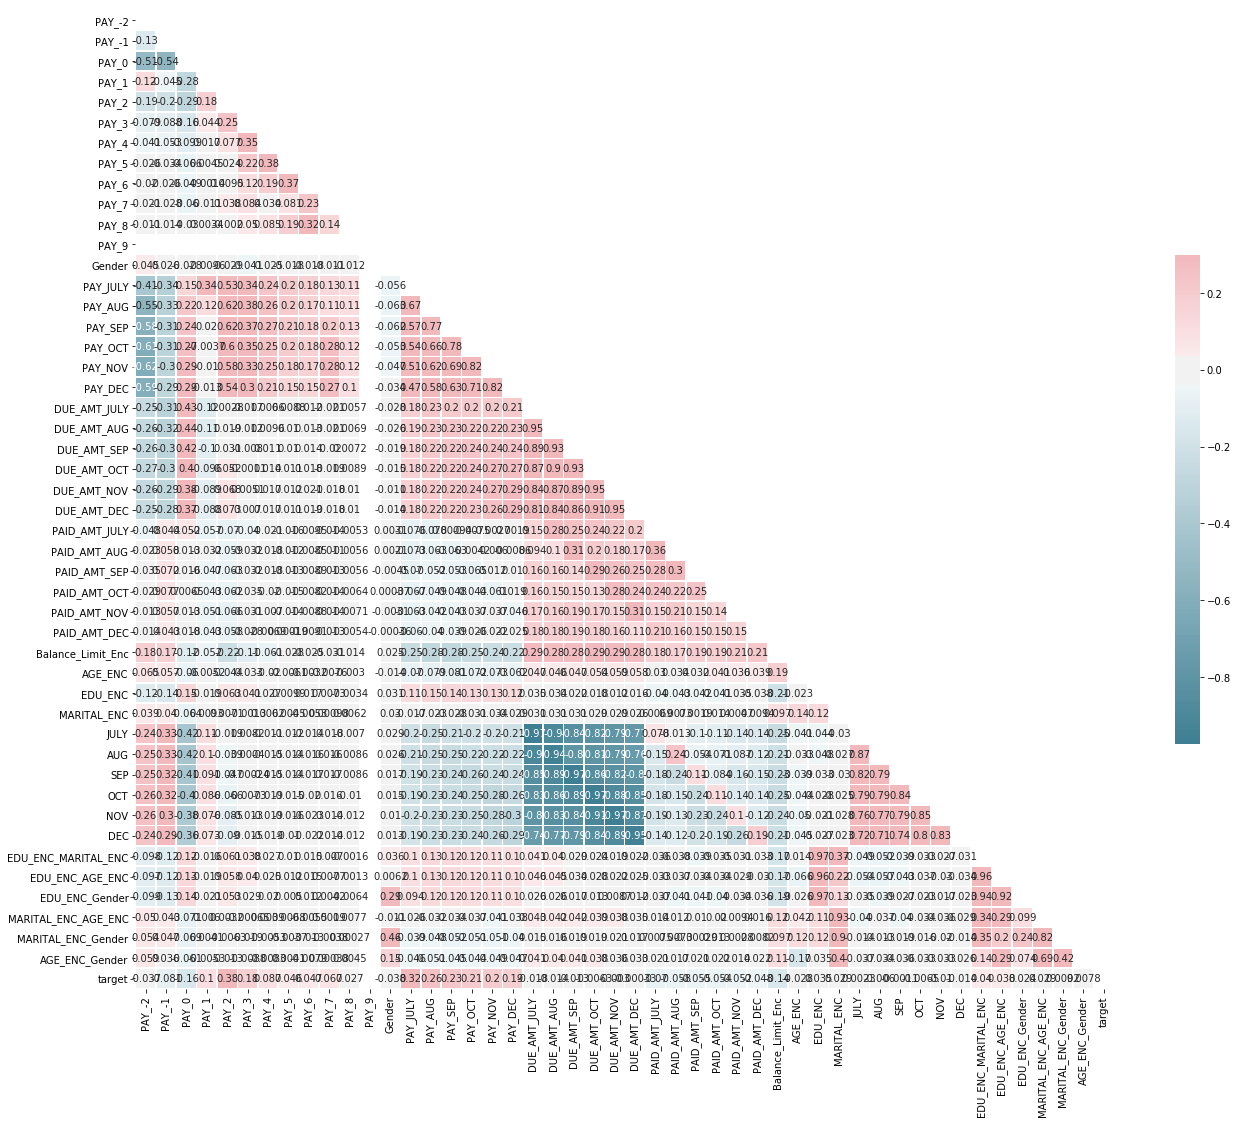

In [392]:
corr = X_train_copy.assign(target = pd.DataFrame(y_train)['NEXT_MONTH_DEFAULT']).corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(22, 18))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

Features selected using models, chi-squared etc. (The code is in another notebook)

In [393]:
features  = ['PAY_JULY',
 'PAY_2',
 'Balance_Limit_Enc',
 'PAY_7',
 'PAY_3',
 'PAY_1',
 'PAY_0',
 'PAID_AMT_SEP',
 'PAID_AMT_NOV',
 'PAID_AMT_JULY',
 'PAID_AMT_DEC',
 'PAID_AMT_AUG']

Evaluation method

In [394]:

def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

In [397]:
print_score = lambda score : print('Mean: %f\t Median: %f' % (score.mean(), median(score)))

In [404]:
fit_params = {
    'early_stopping_rounds' : 5,
    'eval_set': [(X_val_copy[features], y_val)]
}

Using cross validation to identify the best classifer for the dataset with new features

In [407]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

scores = cross_val_score(xgb,X_train_copy[features], y_train, cv=5, fit_params=fit_params)
print_score(scores)

[0]	validation_0-error:0.1805
Will train until validation_0-error hasn't improved in 5 rounds.
[1]	validation_0-error:0.180333
[2]	validation_0-error:0.180333
[3]	validation_0-error:0.180333
[4]	validation_0-error:0.180333
[5]	validation_0-error:0.180333
[6]	validation_0-error:0.180333
Stopping. Best iteration:
[1]	validation_0-error:0.180333

[0]	validation_0-error:0.18
Will train until validation_0-error hasn't improved in 5 rounds.
[1]	validation_0-error:0.18
[2]	validation_0-error:0.18
[3]	validation_0-error:0.18
[4]	validation_0-error:0.18
[5]	validation_0-error:0.18
Stopping. Best iteration:
[0]	validation_0-error:0.18

[0]	validation_0-error:0.180167
Will train until validation_0-error hasn't improved in 5 rounds.
[1]	validation_0-error:0.180167
[2]	validation_0-error:0.180167
[3]	validation_0-error:0.18
[4]	validation_0-error:0.179833
[5]	validation_0-error:0.179667
[6]	validation_0-error:0.179333
[7]	validation_0-error:0.179333
[8]	validation_0-error:0.179333
[9]	validation_0-

In [408]:
from catboost import CatBoostClassifier, Pool

cat = CatBoostClassifier()

scores = cross_val_score(cat,X_train_copy[features], y_train, cv=5, fit_params=fit_params)
print_score(scores)

Learning rate set to 0.061239
0:	learn: 0.6594589	test: 0.6587598	best: 0.6587598 (0)	total: 11.9ms	remaining: 11.8s
1:	learn: 0.6298851	test: 0.6287695	best: 0.6287695 (1)	total: 23.2ms	remaining: 11.6s
2:	learn: 0.6032688	test: 0.6018328	best: 0.6018328 (2)	total: 34.9ms	remaining: 11.6s
3:	learn: 0.5817413	test: 0.5799842	best: 0.5799842 (3)	total: 46.6ms	remaining: 11.6s
4:	learn: 0.5625107	test: 0.5603813	best: 0.5603813 (4)	total: 58.3ms	remaining: 11.6s
5:	learn: 0.5458478	test: 0.5434267	best: 0.5434267 (5)	total: 69.4ms	remaining: 11.5s
6:	learn: 0.5313157	test: 0.5286144	best: 0.5286144 (6)	total: 80.8ms	remaining: 11.5s
7:	learn: 0.5189849	test: 0.5161276	best: 0.5161276 (7)	total: 91.8ms	remaining: 11.4s
8:	learn: 0.5077325	test: 0.5050986	best: 0.5050986 (8)	total: 105ms	remaining: 11.6s
9:	learn: 0.4979945	test: 0.4952135	best: 0.4952135 (9)	total: 117ms	remaining: 11.6s
10:	learn: 0.4903006	test: 0.4874355	best: 0.4874355 (10)	total: 128ms	remaining: 11.5s
11:	learn: 0.4

23:	learn: 0.4472576	test: 0.4414642	best: 0.4414642 (23)	total: 274ms	remaining: 11.1s
24:	learn: 0.4456749	test: 0.4399843	best: 0.4399843 (24)	total: 285ms	remaining: 11.1s
25:	learn: 0.4444481	test: 0.4389136	best: 0.4389136 (25)	total: 296ms	remaining: 11.1s
26:	learn: 0.4430128	test: 0.4376763	best: 0.4376763 (26)	total: 308ms	remaining: 11.1s
27:	learn: 0.4416704	test: 0.4366928	best: 0.4366928 (27)	total: 320ms	remaining: 11.1s
28:	learn: 0.4408067	test: 0.4358848	best: 0.4358848 (28)	total: 332ms	remaining: 11.1s
29:	learn: 0.4399884	test: 0.4351448	best: 0.4351448 (29)	total: 343ms	remaining: 11.1s
30:	learn: 0.4392662	test: 0.4342934	best: 0.4342934 (30)	total: 355ms	remaining: 11.1s
31:	learn: 0.4384959	test: 0.4337755	best: 0.4337755 (31)	total: 366ms	remaining: 11.1s
32:	learn: 0.4376495	test: 0.4330371	best: 0.4330371 (32)	total: 378ms	remaining: 11.1s
33:	learn: 0.4371028	test: 0.4326304	best: 0.4326304 (33)	total: 390ms	remaining: 11.1s
34:	learn: 0.4366214	test: 0.432

17:	learn: 0.4562728	test: 0.4537726	best: 0.4537726 (17)	total: 204ms	remaining: 11.1s
18:	learn: 0.4533290	test: 0.4508895	best: 0.4508895 (18)	total: 215ms	remaining: 11.1s
19:	learn: 0.4509047	test: 0.4483460	best: 0.4483460 (19)	total: 226ms	remaining: 11.1s
20:	learn: 0.4485176	test: 0.4460054	best: 0.4460054 (20)	total: 238ms	remaining: 11.1s
21:	learn: 0.4464260	test: 0.4439528	best: 0.4439528 (21)	total: 249ms	remaining: 11.1s
22:	learn: 0.4444825	test: 0.4422690	best: 0.4422690 (22)	total: 261ms	remaining: 11.1s
23:	learn: 0.4426960	test: 0.4408320	best: 0.4408320 (23)	total: 272ms	remaining: 11.1s
24:	learn: 0.4411266	test: 0.4392872	best: 0.4392872 (24)	total: 286ms	remaining: 11.1s
25:	learn: 0.4398475	test: 0.4381402	best: 0.4381402 (25)	total: 297ms	remaining: 11.1s
26:	learn: 0.4385979	test: 0.4369539	best: 0.4369539 (26)	total: 309ms	remaining: 11.1s
27:	learn: 0.4373692	test: 0.4359591	best: 0.4359591 (27)	total: 320ms	remaining: 11.1s
28:	learn: 0.4365495	test: 0.435

38:	learn: 0.4322296	test: 0.4318081	best: 0.4318081 (38)	total: 457ms	remaining: 11.3s
39:	learn: 0.4317504	test: 0.4314653	best: 0.4314653 (39)	total: 467ms	remaining: 11.2s
40:	learn: 0.4313349	test: 0.4310802	best: 0.4310802 (40)	total: 479ms	remaining: 11.2s
41:	learn: 0.4309976	test: 0.4308216	best: 0.4308216 (41)	total: 492ms	remaining: 11.2s
42:	learn: 0.4306135	test: 0.4306485	best: 0.4306485 (42)	total: 504ms	remaining: 11.2s
43:	learn: 0.4301938	test: 0.4304413	best: 0.4304413 (43)	total: 515ms	remaining: 11.2s
44:	learn: 0.4297614	test: 0.4304794	best: 0.4304413 (43)	total: 527ms	remaining: 11.2s
45:	learn: 0.4293748	test: 0.4303386	best: 0.4303386 (45)	total: 538ms	remaining: 11.2s
46:	learn: 0.4291042	test: 0.4301161	best: 0.4301161 (46)	total: 550ms	remaining: 11.1s
47:	learn: 0.4289006	test: 0.4300069	best: 0.4300069 (47)	total: 562ms	remaining: 11.2s
48:	learn: 0.4286793	test: 0.4297857	best: 0.4297857 (48)	total: 574ms	remaining: 11.1s
49:	learn: 0.4283387	test: 0.429

66:	learn: 0.4236770	test: 0.4272663	best: 0.4272663 (66)	total: 807ms	remaining: 11.2s
67:	learn: 0.4232969	test: 0.4270752	best: 0.4270752 (67)	total: 819ms	remaining: 11.2s
68:	learn: 0.4231073	test: 0.4270737	best: 0.4270737 (68)	total: 831ms	remaining: 11.2s
69:	learn: 0.4228361	test: 0.4270880	best: 0.4270737 (68)	total: 843ms	remaining: 11.2s
70:	learn: 0.4226724	test: 0.4269786	best: 0.4269786 (70)	total: 854ms	remaining: 11.2s
71:	learn: 0.4224497	test: 0.4270114	best: 0.4269786 (70)	total: 868ms	remaining: 11.2s
72:	learn: 0.4222291	test: 0.4270204	best: 0.4269786 (70)	total: 882ms	remaining: 11.2s
73:	learn: 0.4220624	test: 0.4270227	best: 0.4269786 (70)	total: 894ms	remaining: 11.2s
74:	learn: 0.4218877	test: 0.4270767	best: 0.4269786 (70)	total: 905ms	remaining: 11.2s
75:	learn: 0.4215878	test: 0.4270182	best: 0.4269786 (70)	total: 919ms	remaining: 11.2s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.426978578
bestIteration = 70

Shrink model to first 7

In [409]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier()

scores = cross_val_score(lgb,X_train_copy[features], y_train, cv=5, fit_params=fit_params)
print_score(scores)


[1]	valid_0's binary_logloss: 0.511038
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.495632
[3]	valid_0's binary_logloss: 0.483958
[4]	valid_0's binary_logloss: 0.474519
[5]	valid_0's binary_logloss: 0.467069
[6]	valid_0's binary_logloss: 0.460537
[7]	valid_0's binary_logloss: 0.455514
[8]	valid_0's binary_logloss: 0.451313
[9]	valid_0's binary_logloss: 0.447773
[10]	valid_0's binary_logloss: 0.444647
[11]	valid_0's binary_logloss: 0.442493
[12]	valid_0's binary_logloss: 0.440428
[13]	valid_0's binary_logloss: 0.438657
[14]	valid_0's binary_logloss: 0.437389
[15]	valid_0's binary_logloss: 0.436133
[16]	valid_0's binary_logloss: 0.435161
[17]	valid_0's binary_logloss: 0.434215
[18]	valid_0's binary_logloss: 0.433346
[19]	valid_0's binary_logloss: 0.432847
[20]	valid_0's binary_logloss: 0.432172
[21]	valid_0's binary_logloss: 0.431689
[22]	valid_0's binary_logloss: 0.431242
[23]	valid_0's binary_logloss: 0.430827
[24]	valid_0's binary_logloss

It is clear that CatBoost is slightly better than other two for the selected features

### Final Classifier

In [410]:
model = CatBoostClassifier()

X_train, X_val, y_train, y_val =  train_test_split(X, y, test_size=0.02, random_state = 32)

fit_encoders(X_train)

X_train = preprocess(X_train, True)
X_val = preprocess(X_val)
X_test = preprocess(credit_card_default_test)

model.fit(X_train[features], y_train, early_stopping_rounds=5, eval_set=[(X_val[features], y_val)] )

# Here validation report is not useful because the set is small and because we have used it to detect
# overfitting
print_report(X_train, X_val, y_train, y_val, model)

Learning rate set to 0.069128
0:	learn: 0.6551318	test: 0.6568660	best: 0.6568660 (0)	total: 11.5ms	remaining: 11.5s
1:	learn: 0.6230162	test: 0.6263255	best: 0.6263255 (1)	total: 24.9ms	remaining: 12.4s
2:	learn: 0.5946723	test: 0.5985344	best: 0.5985344 (2)	total: 36.5ms	remaining: 12.1s
3:	learn: 0.5709879	test: 0.5749596	best: 0.5749596 (3)	total: 49.7ms	remaining: 12.4s
4:	learn: 0.5506920	test: 0.5553315	best: 0.5553315 (4)	total: 63.5ms	remaining: 12.6s
5:	learn: 0.5337050	test: 0.5381214	best: 0.5381214 (5)	total: 77.5ms	remaining: 12.8s
6:	learn: 0.5186876	test: 0.5236840	best: 0.5236840 (6)	total: 91.4ms	remaining: 13s
7:	learn: 0.5065624	test: 0.5127151	best: 0.5127151 (7)	total: 105ms	remaining: 13s
8:	learn: 0.4960743	test: 0.5031829	best: 0.5031829 (8)	total: 117ms	remaining: 12.9s
9:	learn: 0.4882479	test: 0.4959666	best: 0.4959666 (9)	total: 125ms	remaining: 12.4s
10:	learn: 0.4805612	test: 0.4876645	best: 0.4876645 (10)	total: 140ms	remaining: 12.6s
11:	learn: 0.473818

In [411]:
y_pred = model.predict(X_test)

df = pd.DataFrame({
    'Client_ID' : test_client_ids,
    'NEXT_MONTH_DEFAULT': y_pred
})

NameError: name 'y_pred' is not defined

In [ ]:
df.head()

In [ ]:
df.to_csv('predictions.csv', index = False)